In [1]:
import sys
sys.path.append("/home/ber0061/Repositories/surrDAMH")

In [2]:
import os

import ruamel.yaml as yaml
from surrDAMH.modules import visualization_and_analysis as va
from surrDAMH.modules import analysis as ape
import matplotlib.pyplot as plt
import numpy as np


In [3]:
no_samplers = 19
conf_path = "config_mcmc_bayes.yaml"

basename = os.path.basename(conf_path)
problem_name, fext = os.path.splitext(basename)

output_dir = os.path.join(".", 'saved_samples2', problem_name)


raw_data_dir = os.path.join(output_dir, 'raw_data')
visualization_dir = os.path.join(output_dir, 'img_Bayes')

# načtení dat a formatovani dat

In [4]:

with open(conf_path) as f:
    conf = yaml.safe_load(f)

no_stages = len(conf["samplers_list"])
# parameter chains_disp selects samples from 2. and 3. stage
chains_disp = range(no_samplers, no_samplers * no_stages)
print("chains_disp", chains_disp)

observations = np.array(conf["problem_parameters"]["observations"])

par_names = [p["name"] for p in conf["transformations"]]
print("parameters:", par_names)

if not os.path.exists(visualization_dir):
    os.makedirs(visualization_dir)


chains_disp range(19, 38)
parameters: ['storativity', 'young_modulus', 'init_stress_x', 'init_stress_y', 'perm_kr', 'perm_km', 'perm_beta', 'perm_gamma']


In [5]:
### PREPARATION:
S = va.Samples()
no_parameters = conf["no_parameters"]
scale = ["linear"]*no_parameters


In [6]:

raw_data = ape.RawData()
raw_data.load(output_dir, no_parameters, len(observations))
# type: 0-accepted, 1-prerejected, 2-rejected
raw_data_filtered = raw_data.filter(types=[0,2], stages=range(no_stages+1))
raw_data_accepted = raw_data.filter(types=[0], stages=range(0,no_stages+1))


raw data: no_stages 2
raw data: no_chains 19
raw data: no_samples 495114
raw data: no_nonconverging 0
raw data: p (495114, 8)
raw data: w (495114, 1)
raw_data: np.sum(weights): 490146
filter raw data: p (24844, 8)
filter raw data: p (3328, 8)


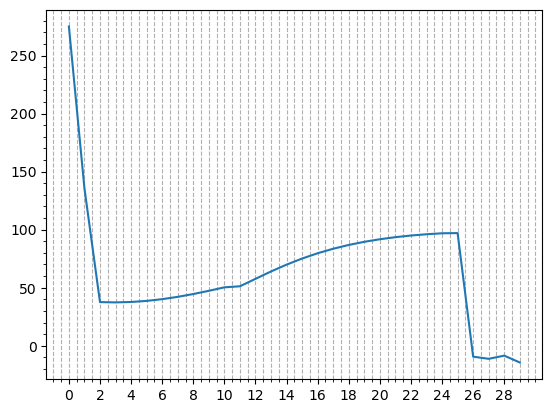

In [7]:
plt.plot(raw_data_accepted.observations[200,:])
# grind in x axis in steplengths 1
plt.xticks(np.arange(0,30,2))
# set minor ticks with step length 1
plt.minorticks_on()

plt.grid(True, which='both', axis='x', linestyle='--')


In [8]:
import surrDAMH.modules.Gaussian_process as gp
cov_mat = gp.assemble_covariance_matrix(conf['noise_model'])

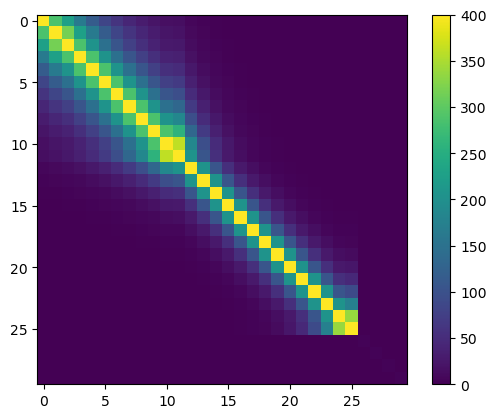

In [9]:
plt.imshow(cov_mat)
plt.colorbar()

In [10]:
def get_log_likelihood_multivariate(observations, G_sample,noise_std):
    v = observations - G_sample.ravel()
    invCv = np.linalg.solve(noise_std,v)
    return -0.5*np.dot(v,invCv)

In [11]:
print(raw_data_accepted.observations.shape)
print(raw_data_accepted.parameters.shape)
n = raw_data_accepted.observations.shape[0]
m = raw_data_accepted.observations.shape[1]
k = raw_data_accepted.parameters.shape[1]
print(n,m,k)

# transform data according to conf['transformations']
parameters_transformed = raw_data_accepted.parameters.copy()

for i in range(k):
    parameters_transformed[:,i] =  (np.log(raw_data_accepted.parameters[:,i]) - conf['transformations'][i]['options']['mu'])/conf['transformations'][i]['options']['sigma']


(3328, 30)
(3328, 8)
3328 30 8


In [12]:
print(raw_data_filtered.observations.shape)
print(raw_data_filtered.parameters.shape)
n_filt = raw_data_filtered.observations.shape[0]
m_filt = raw_data_filtered.observations.shape[1]
k_filt = raw_data_filtered.parameters.shape[1]
print(n,m,k)

# transform data according to conf['transformations']
parameters_transformed_filt = raw_data_filtered.parameters.copy()

for i in range(k):
    parameters_transformed_filt[:,i] =  (np.log(raw_data_filtered.parameters[:,i]) - conf['transformations'][i]['options']['mu'])/conf['transformations'][i]['options']['sigma']


(24844, 30)
(24844, 8)
3328 30 8


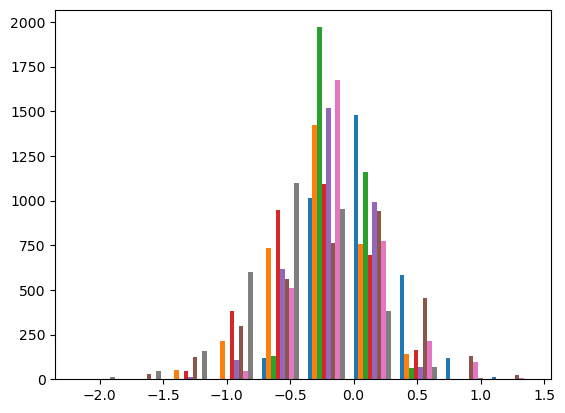

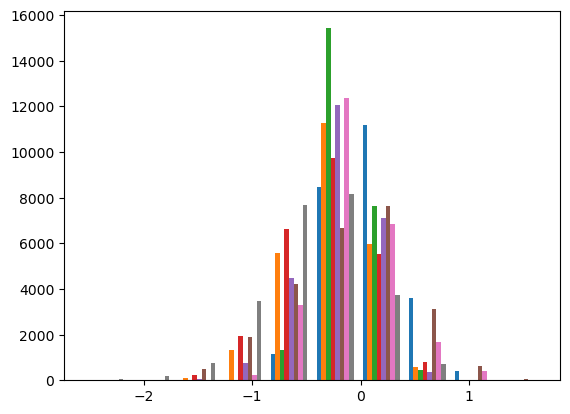

In [13]:
plt.hist(parameters_transformed)
plt.show()
plt.hist(parameters_transformed_filt)
plt.show()

# Polynomialni model

In [14]:
y_orig = np.array(conf['problem_parameters']['observations'])

In [15]:
import surrDAMH.modules.surrogate_poly as surrogate_poly
from surrDAMH.modules.classes_SAMPLER import Snapshot

In [16]:
# create a list of snapshots
snapshots = []

for i in range(n):
    snapshots.append(Snapshot(parameters_transformed[i,:], raw_data_accepted.observations[i,:],weight=raw_data_accepted.weights[i]))


SURROGATE polynomial degree increased to: 1 - no poly: 9
SURROGATE polynomial degree increased to: 3 - no poly: 165


0.7489937208179037


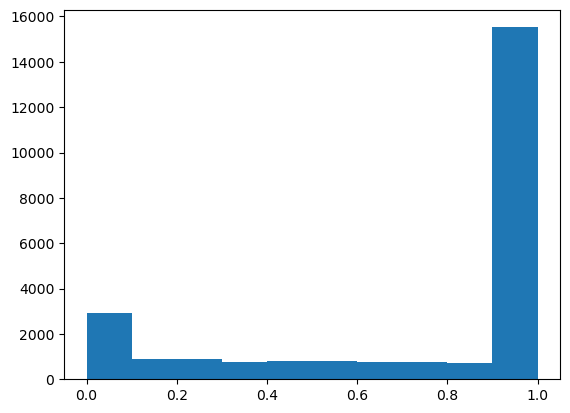

In [17]:
surr_obj = surrogate_poly.Surrogate_update(k,m,max_degree=3)
surr_obj.add_data(snapshots)
SOL = surr_obj.update()
surr_apply_obj = surrogate_poly.Surrogate_apply(k,m)
res_surr = surr_apply_obj.apply(SOL[0], parameters_transformed)
res_surr_filt = surr_apply_obj.apply(SOL[0], parameters_transformed_filt)
res_log_likelihood = np.zeros((len(res_surr_filt),1))

for idx,obs in enumerate(res_surr_filt):
    y_surr = obs
    y_true = raw_data_filtered.observations[idx,:]
    idx2 = np.random.randint(0,n)
    y_surr2 = res_surr[idx2]
    y_true2 = raw_data_accepted.observations[idx2,:]
    res_log_likelihood[idx] = min(get_log_likelihood_multivariate(y_surr,y_orig,cov_mat) - get_log_likelihood_multivariate(y_true,y_orig,cov_mat) -
                                  get_log_likelihood_multivariate(y_surr2,y_orig,cov_mat) + get_log_likelihood_multivariate(y_true2,y_orig,cov_mat),0)

plt.hist(np.exp(res_log_likelihood),bins=10)
print(np.sum(np.exp(res_log_likelihood).ravel() > np.random.rand(len(res_log_likelihood)))/len(res_log_likelihood))

SURROGATE polynomial degree increased to: 1 - no poly: 9
SURROGATE polynomial degree increased to: 4 - no poly: 495
0.7556351634197391


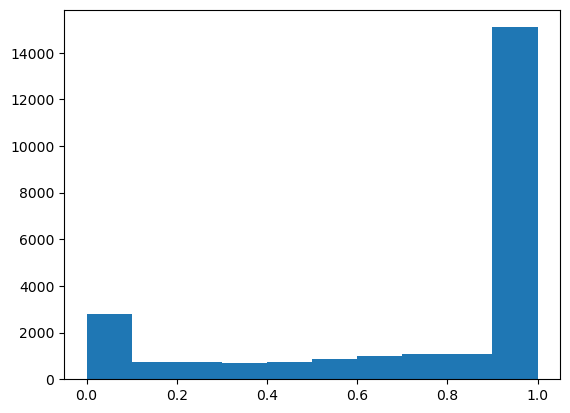

In [18]:
surr_obj = surrogate_poly.Surrogate_update(k,m,max_degree=4)
surr_obj.add_data(snapshots)
SOL = surr_obj.update()
surr_apply_obj = surrogate_poly.Surrogate_apply(k,m)
res_surr = surr_apply_obj.apply(SOL[0], parameters_transformed)
res_surr_filt = surr_apply_obj.apply(SOL[0], parameters_transformed_filt)
res_log_likelihood = np.zeros((len(res_surr_filt),1))

for idx,obs in enumerate(res_surr_filt):
    y_surr = obs
    y_true = raw_data_filtered.observations[idx,:]
    idx2 = np.random.randint(0,n)
    y_surr2 = res_surr[idx2]
    y_true2 = raw_data_accepted.observations[idx2,:]
    res_log_likelihood[idx] = min(get_log_likelihood_multivariate(y_surr,y_orig,cov_mat) - get_log_likelihood_multivariate(y_true,y_orig,cov_mat) -
                                  get_log_likelihood_multivariate(y_surr2,y_orig,cov_mat) + get_log_likelihood_multivariate(y_true2,y_orig,cov_mat),0)

plt.hist(np.exp(res_log_likelihood),bins=10)
print(np.sum(np.exp(res_log_likelihood).ravel() > np.random.rand(len(res_log_likelihood)))/len(res_log_likelihood))

SURROGATE polynomial degree increased to: 1 - no poly: 9
SURROGATE polynomial degree increased to: 6 - no poly: 3003
0.37912574464659476


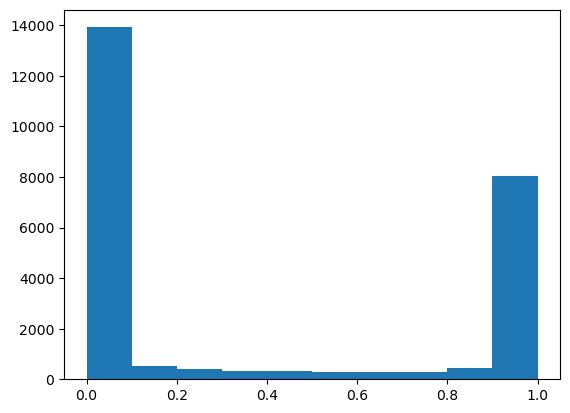

In [19]:
surr_obj = surrogate_poly.Surrogate_update(k,m,max_degree=6)
surr_obj.add_data(snapshots)
SOL = surr_obj.update()
surr_apply_obj = surrogate_poly.Surrogate_apply(k,m)
res_surr = surr_apply_obj.apply(SOL[0], parameters_transformed)
res_surr_filt = surr_apply_obj.apply(SOL[0], parameters_transformed_filt)
res_log_likelihood = np.zeros((len(res_surr_filt),1))

for idx,obs in enumerate(res_surr_filt):
    y_surr = obs
    y_true = raw_data_filtered.observations[idx,:]
    idx2 = np.random.randint(0,n)
    y_surr2 = res_surr[idx2]
    y_true2 = raw_data_accepted.observations[idx2,:]
    res_log_likelihood[idx] = min(get_log_likelihood_multivariate(y_surr,y_orig,cov_mat) - get_log_likelihood_multivariate(y_true,y_orig,cov_mat) -
                                  get_log_likelihood_multivariate(y_surr2,y_orig,cov_mat) + get_log_likelihood_multivariate(y_true2,y_orig,cov_mat),0)

plt.hist(np.exp(res_log_likelihood),bins=10)
print(np.sum(np.exp(res_log_likelihood).ravel() > np.random.rand(len(res_log_likelihood)))/len(res_log_likelihood))

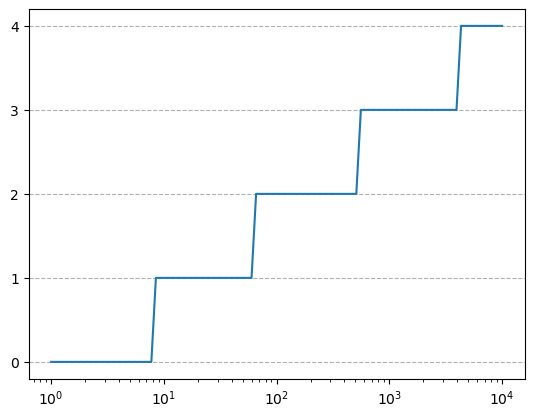

In [20]:

x = np.logspace(0, 4, num=100, base=10)
plt.plot(x,np.floor(np.log(x)/np.log(8)))
# set x axis to log scale
plt.xscale('log')
# set y ticks to 0,1,2,3,4
plt.yticks(np.arange(0,5,1))
plt.grid(True, which='both', axis='y', linestyle='--')

## polynomial modell with all data from preaccepted


In [21]:
# create a list of snapshots
snapshots = []

for i in range(n_filt):
    snapshots.append(Snapshot(parameters_transformed_filt[i,:], raw_data_filtered.observations[i,:],weight=raw_data_filtered.weights[i]))


SURROGATE polynomial degree increased to: 1 - no poly: 9
SURROGATE polynomial degree increased to: 3 - no poly: 165
0.7581709869586218


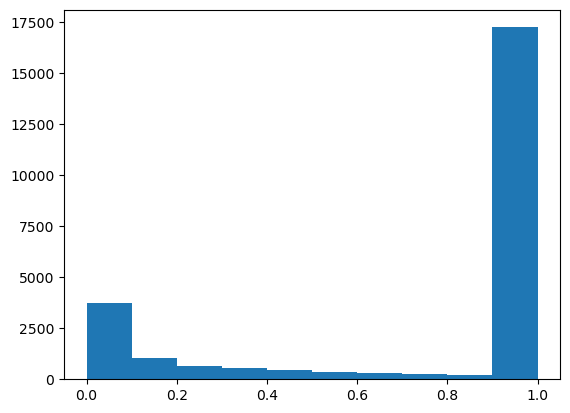

In [22]:
surr_obj = surrogate_poly.Surrogate_update(k,m,max_degree=3)
surr_obj.add_data(snapshots)
SOL = surr_obj.update()
surr_apply_obj = surrogate_poly.Surrogate_apply(k,m)
res_surr = surr_apply_obj.apply(SOL[0], parameters_transformed)
res_surr_filt = surr_apply_obj.apply(SOL[0], parameters_transformed_filt)
res_log_likelihood = np.zeros((len(res_surr_filt),1))

for idx,obs in enumerate(res_surr_filt):
    y_surr = obs
    y_true = raw_data_filtered.observations[idx,:]
    idx2 = np.random.randint(0,n)
    y_surr2 = res_surr[idx2]
    y_true2 = raw_data_accepted.observations[idx2,:]
    res_log_likelihood[idx] = min(get_log_likelihood_multivariate(y_surr,y_orig,cov_mat) - get_log_likelihood_multivariate(y_true,y_orig,cov_mat) -
                                  get_log_likelihood_multivariate(y_surr2,y_orig,cov_mat) + get_log_likelihood_multivariate(y_true2,y_orig,cov_mat),0)

plt.hist(np.exp(res_log_likelihood),bins=10)
print(np.sum(np.exp(res_log_likelihood).ravel() > np.random.rand(len(res_log_likelihood)))/len(res_log_likelihood))

SURROGATE polynomial degree increased to: 1 - no poly: 9
SURROGATE polynomial degree increased to: 6 - no poly: 3003
0.7105538560618258


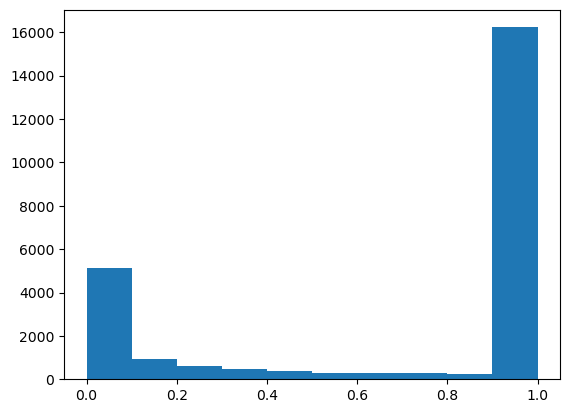

In [23]:
surr_obj = surrogate_poly.Surrogate_update(k,m,max_degree=6)
surr_obj.add_data(snapshots)
SOL = surr_obj.update()
surr_apply_obj = surrogate_poly.Surrogate_apply(k,m)
res_surr = surr_apply_obj.apply(SOL[0], parameters_transformed)
res_surr_filt = surr_apply_obj.apply(SOL[0], parameters_transformed_filt)
res_log_likelihood = np.zeros((len(res_surr_filt),1))

for idx,obs in enumerate(res_surr_filt):
    y_surr = obs
    y_true = raw_data_filtered.observations[idx,:]
    idx2 = np.random.randint(0,n)
    y_surr2 = res_surr[idx2]
    y_true2 = raw_data_accepted.observations[idx2,:]
    res_log_likelihood[idx] = min(get_log_likelihood_multivariate(y_surr,y_orig,cov_mat) - get_log_likelihood_multivariate(y_true,y_orig,cov_mat) -
                                  get_log_likelihood_multivariate(y_surr2,y_orig,cov_mat) + get_log_likelihood_multivariate(y_true2,y_orig,cov_mat),0)

plt.hist(np.exp(res_log_likelihood),bins=10)
print(np.sum(np.exp(res_log_likelihood).ravel() > np.random.rand(len(res_log_likelihood)))/len(res_log_likelihood))

0.7170342939945259


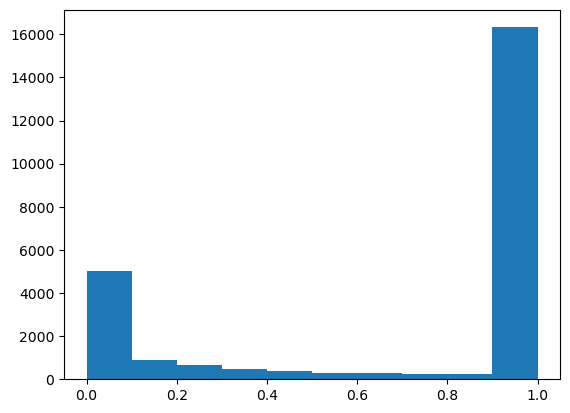

In [24]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def polynomial_regression(X, y, degree):
    # Create a pipeline that first creates polynomial features and then fits a linear regression model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X, y)
    return model

tmp = polynomial_regression(parameters_transformed_filt, raw_data_filtered.observations,6)
res_surr_filt = tmp.predict(parameters_transformed_filt)
res_surr = tmp.predict(parameters_transformed)

res_log_likelihood = np.zeros((len(res_surr_filt),1))

for idx,obs in enumerate(res_surr_filt):
    y_surr = obs
    y_true = raw_data_filtered.observations[idx,:]
    idx2 = np.random.randint(0,n)
    y_surr2 = res_surr[idx2]
    y_true2 = raw_data_accepted.observations[idx2,:]
    res_log_likelihood[idx] = min(get_log_likelihood_multivariate(y_surr,y_orig,cov_mat) - get_log_likelihood_multivariate(y_true,y_orig,cov_mat) -
                                  get_log_likelihood_multivariate(y_surr2,y_orig,cov_mat) + get_log_likelihood_multivariate(y_true2,y_orig,cov_mat),0)

plt.hist(np.exp(res_log_likelihood),bins=10)
print(np.sum(np.exp(res_log_likelihood).ravel() > np.random.rand(len(res_log_likelihood)))/len(res_log_likelihood))


## Kontrola skrze scikit-learn

In [20]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def polynomial_regression(X, y, degree):
    # Create a pipeline that first creates polynomial features and then fits a linear regression model
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X, y)
    return model


0.7564401867654162


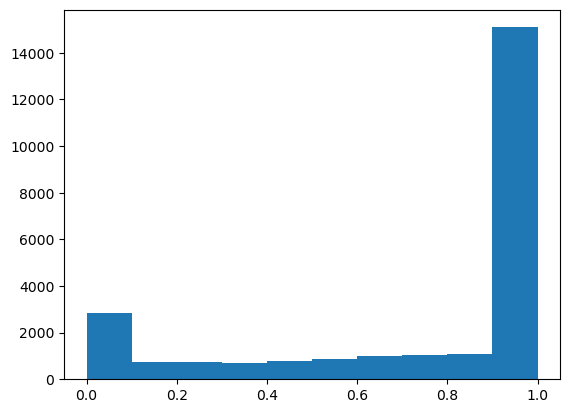

In [21]:
tmp = polynomial_regression(parameters_transformed, raw_data_accepted.observations,4)
res_surr_filt = tmp.predict(parameters_transformed_filt)
res_surr = tmp.predict(parameters_transformed)

res_log_likelihood = np.zeros((len(res_surr_filt),1))

for idx,obs in enumerate(res_surr_filt):
    y_surr = obs
    y_true = raw_data_filtered.observations[idx,:]
    idx2 = np.random.randint(0,n)
    y_surr2 = res_surr[idx2]
    y_true2 = raw_data_accepted.observations[idx2,:]
    res_log_likelihood[idx] = min(get_log_likelihood_multivariate(y_surr,y_orig,cov_mat) - get_log_likelihood_multivariate(y_true,y_orig,cov_mat) -
                                  get_log_likelihood_multivariate(y_surr2,y_orig,cov_mat) + get_log_likelihood_multivariate(y_true2,y_orig,cov_mat),0)

plt.hist(np.exp(res_log_likelihood),bins=10)
print(np.sum(np.exp(res_log_likelihood).ravel() > np.random.rand(len(res_log_likelihood)))/len(res_log_likelihood))


# RBF model

In [18]:
from surrDAMH.modules import surrogate_rbf

0.8741345999033971


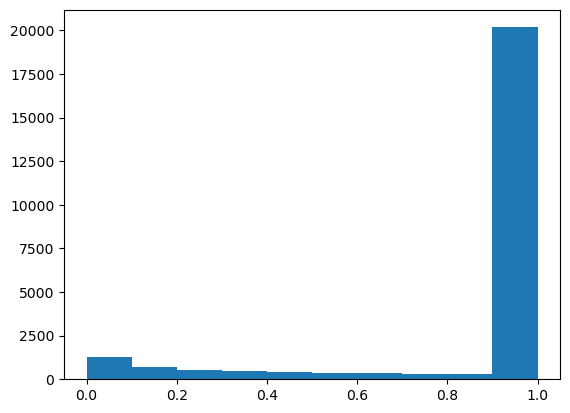

In [19]:
surr_obj = surrogate_rbf.Surrogate_update(no_parameters=k, no_observations=m, 
                                          initial_iteration=None, no_keep=100, expensive=False, 
                                          kernel_type=0, solver_tol_exp=-6, solver_type='minres')
surr_obj.add_data(snapshots)
SOL = surr_obj.update()
surr_apply_obj = surrogate_rbf.Surrogate_apply(k,m,kernel_type=0)
res_surr = surr_apply_obj.apply(SOL[0], parameters_transformed)
res_surr_filt = surr_apply_obj.apply(SOL[0], parameters_transformed_filt)
res_log_likelihood = np.zeros((len(res_surr_filt),1))

for idx,obs in enumerate(res_surr_filt):
    y_surr = obs
    y_true = raw_data_filtered.observations[idx,:]
    idx2 = np.random.randint(0,n)
    y_surr2 = res_surr[idx2]
    y_true2 = raw_data_accepted.observations[idx2,:]
    res_log_likelihood[idx] = min(get_log_likelihood_multivariate(y_surr,y_orig,cov_mat) - get_log_likelihood_multivariate(y_true,y_orig,cov_mat) -
                                  get_log_likelihood_multivariate(y_surr2,y_orig,cov_mat) + get_log_likelihood_multivariate(y_true2,y_orig,cov_mat),0)

plt.hist(np.exp(res_log_likelihood),bins=10)
print(np.sum(np.exp(res_log_likelihood).ravel() > np.random.rand(len(res_log_likelihood)))/len(res_log_likelihood))

0.8935759137014974


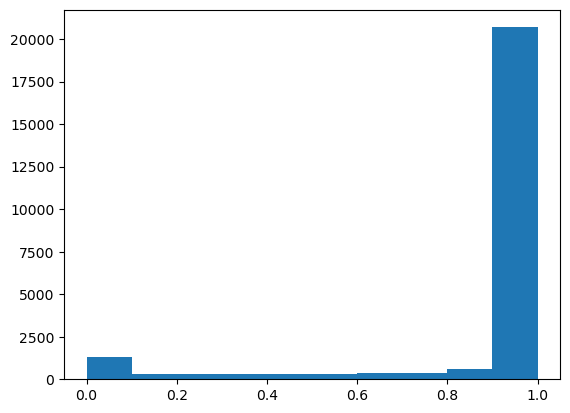

In [143]:
surr_obj = surrogate_rbf.Surrogate_update(no_parameters=k, no_observations=m, 
                                          initial_iteration=None, no_keep=10000, expensive=False, 
                                          kernel_type=0, solver_tol_exp=-6, solver_type='minres')
surr_obj.add_data(snapshots)
SOL = surr_obj.update()
surr_apply_obj = surrogate_rbf.Surrogate_apply(k,m,kernel_type=0)
res_surr = surr_apply_obj.apply(SOL[0], parameters_transformed)
res_surr_filt = surr_apply_obj.apply(SOL[0], parameters_transformed_filt)
res_log_likelihood = np.zeros((len(res_surr_filt),1))

for idx,obs in enumerate(res_surr_filt):
    y_surr = obs
    y_true = raw_data_filtered.observations[idx,:]
    idx2 = np.random.randint(0,n)
    y_surr2 = res_surr[idx2]
    y_true2 = raw_data_accepted.observations[idx2,:]
    res_log_likelihood[idx] = min(get_log_likelihood_multivariate(y_surr,y_orig,cov_mat) - get_log_likelihood_multivariate(y_true,y_orig,cov_mat) -
                                  get_log_likelihood_multivariate(y_surr2,y_orig,cov_mat) + get_log_likelihood_multivariate(y_true2,y_orig,cov_mat),0)

plt.hist(np.exp(res_log_likelihood),bins=10)
print(np.sum(np.exp(res_log_likelihood).ravel() > np.random.rand(len(res_log_likelihood)))/len(res_log_likelihood))

0.7609080663339237


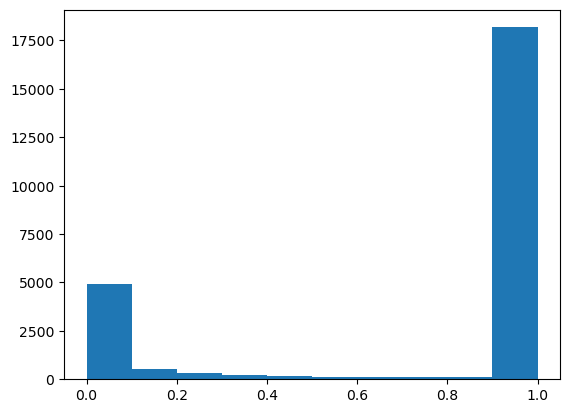

In [ ]:
surr_obj = surrogate_rbf.Surrogate_update(no_parameters=k, no_observations=m, 
                                          initial_iteration=None, no_keep=10000, expensive=False, 
                                          kernel_type=2, solver_tol_exp=-6, solver_type='minres')
surr_obj.add_data(snapshots)
SOL = surr_obj.update()
surr_apply_obj = surrogate_rbf.Surrogate_apply(k,m,kernel_type=0)
res_surr = surr_apply_obj.apply(SOL[0], parameters_transformed)
res_surr_filt = surr_apply_obj.apply(SOL[0], parameters_transformed_filt)
res_log_likelihood = np.zeros((len(res_surr_filt),1))

for idx,obs in enumerate(res_surr_filt):
    y_surr = obs
    y_true = raw_data_filtered.observations[idx,:]
    idx2 = np.random.randint(0,n)
    y_surr2 = res_surr[idx2]
    y_true2 = raw_data_accepted.observations[idx2,:]
    res_log_likelihood[idx] = min(get_log_likelihood_multivariate(y_surr,y_orig,cov_mat) - get_log_likelihood_multivariate(y_true,y_orig,cov_mat) -
                                  get_log_likelihood_multivariate(y_surr2,y_orig,cov_mat) + get_log_likelihood_multivariate(y_true2,y_orig,cov_mat),0)

plt.hist(np.exp(res_log_likelihood),bins=10)
print(np.sum(np.exp(res_log_likelihood).ravel() > np.random.rand(len(res_log_likelihood)))/len(res_log_likelihood))

0.6228063113830301


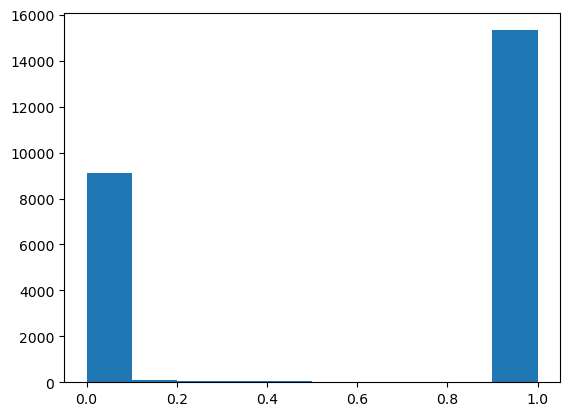

In [ ]:
surr_obj = surrogate_rbf.Surrogate_update(no_parameters=k, no_observations=m, 
                                          initial_iteration=None, no_keep=10000, expensive=False, 
                                          kernel_type=1, solver_tol_exp=-6, solver_type='minres')
surr_obj.add_data(snapshots)
SOL = surr_obj.update()
surr_apply_obj = surrogate_rbf.Surrogate_apply(k,m,kernel_type=0)
res_surr = surr_apply_obj.apply(SOL[0], parameters_transformed)
res_surr_filt = surr_apply_obj.apply(SOL[0], parameters_transformed_filt)
res_log_likelihood = np.zeros((len(res_surr_filt),1))

for idx,obs in enumerate(res_surr_filt):
    y_surr = obs
    y_true = raw_data_filtered.observations[idx,:]
    idx2 = np.random.randint(0,n)
    y_surr2 = res_surr[idx2]
    y_true2 = raw_data_accepted.observations[idx2,:]
    res_log_likelihood[idx] = min(get_log_likelihood_multivariate(y_surr,y_orig,cov_mat) - get_log_likelihood_multivariate(y_true,y_orig,cov_mat) -
                                  get_log_likelihood_multivariate(y_surr2,y_orig,cov_mat) + get_log_likelihood_multivariate(y_true2,y_orig,cov_mat),0)

plt.hist(np.exp(res_log_likelihood),bins=10)
print(np.sum(np.exp(res_log_likelihood).ravel() > np.random.rand(len(res_log_likelihood)))/len(res_log_likelihood))

# RBF pomocí scikit-learn

In [60]:
import numpy as np
import matplotlib.pyplot as plt

from smt.surrogate_models import RBF

# Create and train the model
sm = RBF(d0=1, poly_degree=1)
sm.set_training_values(parameters_transformed, raw_data_accepted.observations)
sm.train()


___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 3328
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing linear solver ...
         Performing LU fact. (3337 x 3337 mtx) ...
         Performing LU fact. (3337 x 3337 mtx) - done. Time (sec):  2.5689652
      Initializing linear solver - done. Time (sec):  2.5691316
      Solving linear system (col. 0) ...
         Back solving (3337 x 3337 mtx) ...
         Back solving (3337 x 3337 mtx) - done. Time (sec):  0.0148621
      Solving linear system (col. 0) - done. Time (sec):  0.0149779
      Solving linear system (col. 1) ...
         Back solving (3337 x 3337 mtx) ...
         Back solving (3337 x 3337 mtx) - done. Time (sec):  0.0144973
      Solving linea

In [61]:

# Test the model
res_surr_filt = sm.predict_values(parameters_transformed_filt)
res_surr = sm.predict_values(parameters_transformed)

___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 24844
   
   Predicting ...
   Predicting - done. Time (sec):  4.3448374
   
   Prediction time/pt. (sec) :  0.0001749
   
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 3328
   
   Predicting ...
   Predicting - done. Time (sec):  0.6232836
   
   Prediction time/pt. (sec) :  0.0001873
   


0.7103123490581227


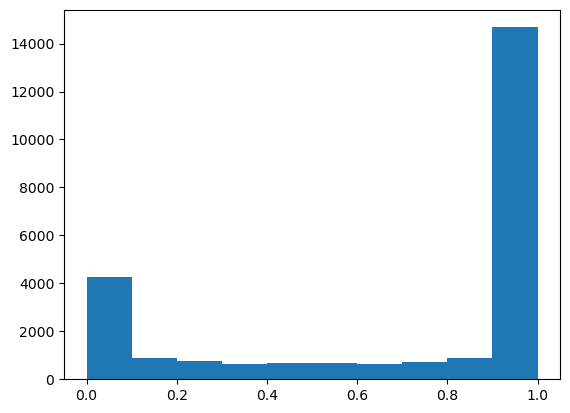

In [62]:
res_log_likelihood = np.zeros((len(res_surr_filt),1))

for idx,obs in enumerate(res_surr_filt):
    y_surr = obs
    y_true = raw_data_filtered.observations[idx,:]
    idx2 = np.random.randint(0,n)
    y_surr2 = res_surr[idx2]
    y_true2 = raw_data_accepted.observations[idx2,:]
    res_log_likelihood[idx] = min(get_log_likelihood_multivariate(y_surr,y_orig,cov_mat) - get_log_likelihood_multivariate(y_true,y_orig,cov_mat) -
                                  get_log_likelihood_multivariate(y_surr2,y_orig,cov_mat) + get_log_likelihood_multivariate(y_true2,y_orig,cov_mat),0)

plt.hist(np.exp(res_log_likelihood),bins=10)
print(np.sum(np.exp(res_log_likelihood).ravel() > np.random.rand(len(res_log_likelihood)))/len(res_log_likelihood))

0.9999194976654323


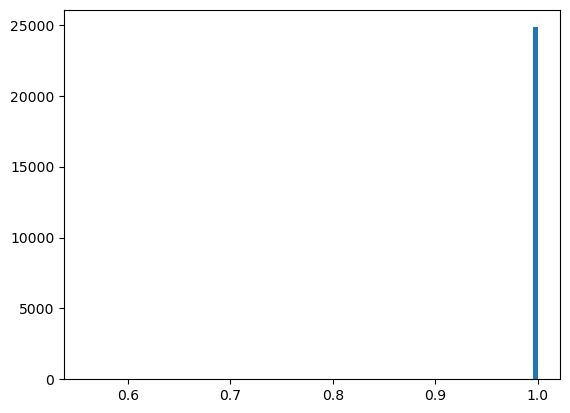

In [155]:
from scipy.interpolate import RBFInterpolator

# Použití funkce surrogate_model
"""    kernel: typ jaderné funkce ('linear', 'thin_plate_spline', 'cubic', 'quintic', 'multiquadric', 
             'inverse_multiquadric', 'inverse_quadratic', 'gaussian')"""
tmp = RBFInterpolator(parameters_transformed, raw_data_accepted.observations, kernel='inverse_quadratic',degree=0, epsilon=10)
res_surr_filt = tmp(parameters_transformed_filt)
res_surr = tmp(parameters_transformed)

res_log_likelihood = np.zeros((len(res_surr_filt),1))

for idx,obs in enumerate(res_surr_filt):
    y_surr = obs
    y_true = raw_data_filtered.observations[idx,:]
    idx2 = np.random.randint(0,n)
    y_surr2 = res_surr[idx2]
    y_true2 = raw_data_accepted.observations[idx2,:]
    res_log_likelihood[idx] = min(get_log_likelihood_multivariate(y_surr,y_orig,cov_mat) - get_log_likelihood_multivariate(y_true,y_orig,cov_mat) -
                                  get_log_likelihood_multivariate(y_surr2,y_orig,cov_mat) + get_log_likelihood_multivariate(y_true2,y_orig,cov_mat),0)

plt.hist(np.exp(res_log_likelihood),bins=100)
print(np.sum(np.exp(res_log_likelihood).ravel() > np.random.rand(len(res_log_likelihood)))/len(res_log_likelihood))

In [261]:
#  compute get_log_likelihood_multivariate(y_true,y_orig,cov_mat) for each y_true = raw_data_filtered.observations[idx,:]

acc_likelihood = np.zeros((len(res_surr),1))
for idx,obs in enumerate(raw_data_accepted.observations):
    acc_likelihood[idx] = get_log_likelihood_multivariate(obs,y_orig,cov_mat)

filt_likelihood = np.zeros((len(raw_data_filtered.observations),1))
for idx,obs in enumerate(raw_data_filtered.observations):
    filt_likelihood[idx] = get_log_likelihood_multivariate(obs,y_orig,cov_mat)

In [262]:
all_data = parameters_transformed_filt[filt_likelihood.ravel() > -5,:]
all_result = raw_data_filtered.observations[filt_likelihood.ravel() > -5, :]

# create two sets of data of all_data and all_result one for training and one for testing 10% for training
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_data, all_result, test_size=0.8, random_state=42)

In [263]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1793, 8)
(7175, 8)
(1793, 30)
(7175, 30)


In [319]:
from scipy.interpolate import RBFInterpolator

# Použití funkce surrogate_model
"""    kernel: typ jaderné funkce ('linear', 'thin_plate_spline', 'cubic', 'quintic', 'multiquadric', 
             'inverse_multiquadric', 'inverse_quadratic', 'gaussian')"""
tmp = RBFInterpolator(X_train, y_train, kernel='linear',degree=1, epsilon=1)
res_surr_filt = tmp(X_test)



acc_likelihood = np.zeros((len(res_surr_filt),1))
for idx,obs in enumerate(res_surr_filt):
    acc_likelihood[idx] = get_log_likelihood_multivariate(obs,y_orig,cov_mat)

filt_likelihood = np.zeros((len(y_test),1))
for idx,obs in enumerate(y_test):
    filt_likelihood[idx] = get_log_likelihood_multivariate(obs,y_orig,cov_mat)



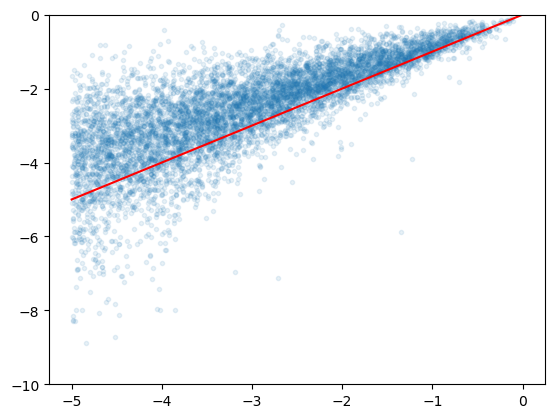

In [320]:

plt.scatter(filt_likelihood,acc_likelihood,alpha=0.1,marker='.')
# plot red linear regression line on -5 to 0
plt.plot([-5,0],[-5,0],color='red')
# limit y axis to -10 to 0
plt.ylim(-10,0)
plt.show()

In [356]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

# předpokládáme, že `input_data` je vaše vstupní data o rozměrech (n, 8)
# a `output_data` jsou odpovídající měření o rozměrech (n, 30)
input_data = all_data
output_data = all_result

# rozdělit data na trénovací a testovací set
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.5, random_state=42)

# vytvořit instanci MLPRegressoru
mlp = MLPRegressor(hidden_layer_sizes=(200,),activation='logistic', solver='adam', max_iter=50000, verbose=True)

# trénovat model
mlp.fit(X_train, y_train)




Iteration 1, loss = 3731.72866213
Iteration 2, loss = 3561.42414693
Iteration 3, loss = 3384.41056175
Iteration 4, loss = 3199.49625859
Iteration 5, loss = 3008.93566907
Iteration 6, loss = 2815.93810485
Iteration 7, loss = 2623.90918848
Iteration 8, loss = 2435.92926782
Iteration 9, loss = 2254.72339004
Iteration 10, loss = 2082.55655330
Iteration 11, loss = 1920.89240357
Iteration 12, loss = 1770.50975157
Iteration 13, loss = 1632.15509559
Iteration 14, loss = 1505.66223932
Iteration 15, loss = 1390.56878793
Iteration 16, loss = 1286.52656417
Iteration 17, loss = 1192.82153480
Iteration 18, loss = 1108.38759893
Iteration 19, loss = 1032.60434516
Iteration 20, loss = 964.63194464
Iteration 21, loss = 903.51589362
Iteration 22, loss = 848.57706645
Iteration 23, loss = 799.04493025
Iteration 24, loss = 754.21860614
Iteration 25, loss = 713.63935095
Iteration 26, loss = 676.56456288
Iteration 27, loss = 642.69736805
Iteration 28, loss = 611.46334248
Iteration 29, loss = 582.64804724
Iter

MLPRegressor(activation='logistic', hidden_layer_sizes=(200,), max_iter=50000,
             verbose=True)

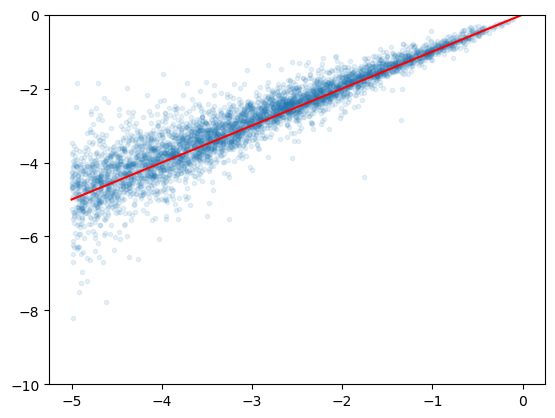

In [357]:
# testovat model
predictions = mlp.predict(X_test)

acc_likelihood = np.zeros((len(predictions),1))
for idx,obs in enumerate(predictions):
    acc_likelihood[idx] = get_log_likelihood_multivariate(obs,y_orig,cov_mat)

filt_likelihood = np.zeros((len(y_test),1))
for idx,obs in enumerate(y_test):
    filt_likelihood[idx] = get_log_likelihood_multivariate(obs,y_orig,cov_mat)


plt.scatter(filt_likelihood,acc_likelihood,alpha=0.1,marker='.')
# plot red linear regression line on -5 to 0
plt.plot([-5,0],[-5,0],color='red')
# limit y axis to -10 to 0
plt.ylim(-10,0)
plt.show()

0.8372370095904694


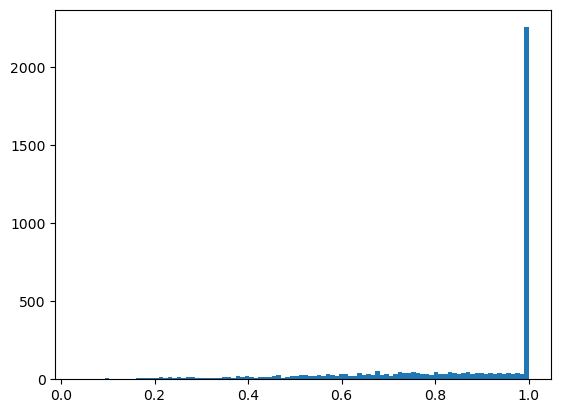

In [374]:
# create random permutation of filt_likelihood,acc_likelihood
idx = np.random.permutation(len(filt_likelihood))
filt_likelihood_old = filt_likelihood[idx]
acc_likelihood_old = acc_likelihood[idx]

alpha_s = np.minimum(filt_likelihood + acc_likelihood_old - filt_likelihood_old - acc_likelihood,0)

plt.hist(np.exp(alpha_s),bins=100)
print(np.mean(np.exp(alpha_s)))

In [367]:
max(alpha_s)

array([0.])